# Time Series Model ( AR(2) )

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
warnings.simplefilter(action="ignore")

# Updrs_1

In [43]:
# read clinical dataset from the file
clinical = pd.read_csv("train_clinical_data.csv")


In [44]:
# generate four new columns for four 
# different-lag effects, including 3, 6, 9, 12 months
clinical['updrs_1_lag3'] = np.nan
clinical['updrs_1_lag6'] = np.nan
clinical['updrs_1_lag9'] = np.nan
clinical['updrs_1_lag12'] = np.nan


for id in clinical.patient_id.unique():
    # we calculate lagged\previous value for one patient in one for-loop
    dt_id = clinical[clinical.patient_id == id]
    # get the patient_id and substract the check-ups data of that patient from original dataframe
    if dt_id.shape[0] == 1:
        # if this patient has only one row, this patient will not have the lagged value
        continue
    for i in range(1,len(dt_id.index)):
        # because of the lagged/previous value, we do this for-loop from the second check-up
        index = dt_id.index[i]
        # get the index of this check-up in the original dataframe
        if not dt_id[dt_id.visit_month == 
                     dt_id.visit_month[dt_id.index[i]] - 3 ].empty:
            # judge whether this check-up has previous check-up 3 months ago
            lag3_index = dt_id[dt_id.visit_month == 
                               dt_id.visit_month[dt_id.index[i]] 
                               - 3 ].index[0]
            # get the index of check-up row 3 months ago in the original dataframe
            clinical['updrs_1_lag3'][index] =  clinical['updrs_1'][
                lag3_index]
            # assign the lagged value we find to the corresponding variable
        # do the same procedure as 3-month part for 6-month, 9-month, 12-month
        if not dt_id[dt_id.visit_month == 
                     dt_id.visit_month[dt_id.index[i]] - 6 ].empty:
            lag6_index = dt_id[dt_id.visit_month == 
                               dt_id.visit_month[dt_id.index[i]] 
                               - 6 ].index[0]
            clinical['updrs_1_lag6'][index] =  clinical['updrs_1'][
                lag6_index]
        if not dt_id[dt_id.visit_month == 
                     dt_id.visit_month[dt_id.index[i]] - 9 ].empty:
            lag9_index = dt_id[dt_id.visit_month == 
                               dt_id.visit_month[dt_id.index[i]] 
                               - 9 ].index[0]
            clinical['updrs_1_lag9'][index] =  clinical['updrs_1'][
                lag9_index]
        if not dt_id[dt_id.visit_month == 
                     dt_id.visit_month[dt_id.index[i]] - 12 ].empty:
            lag12_index = dt_id[dt_id.visit_month == 
                                dt_id.visit_month[dt_id.index[i]] 
                                - 12 ].index[0]
            clinical['updrs_1_lag12'][index] =  clinical['updrs_1'][
                lag12_index]


In [45]:
updrs_1_ar = clinical[['updrs_1','updrs_1_lag3',
                       'updrs_1_lag6','updrs_1_lag9','updrs_1_lag12']]
# substract the columns we focus from the clinical dataframe
updrs_1_ar.corr()
# calculate the covariance matrix

,updrs_1,updrs_1_lag3,updrs_1_lag6,updrs_1_lag9,updrs_1_lag12
updrs_1,1.000000,0.783087,0.801096,0.700314,0.803501
updrs_1_lag3,0.783087,1.000000,0.771940,0.709902,0.707427
updrs_1_lag6,0.801096,0.771940,1.000000,0.784658,0.792896
updrs_1_lag9,0.700314,0.709902,0.784658,1.000000,0.765280
updrs_1_lag12,0.803501,0.707427,0.792896,0.765280,1.000000


In [46]:
updrs_1_ar1 = clinical[['updrs_1','updrs_1_lag6','updrs_1_lag12']]
# substract the columns we use in our AR model
print(updrs_1_ar1.shape)
# print out the total dataset size 
updrs_1_ar1.dropna(axis = 0,inplace = True)
# drop the rows with na values make regression successful
print(updrs_1_ar1.shape)
# print out the valid dataset size


(2615, 3)
(1371, 3)


                            OLS Regression Results                            
Dep. Variable:                updrs_1   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     1325.
Date:                Wed, 03 May 2023   Prob (F-statistic):          6.13e-293
Time:                        17:59:21   Log-Likelihood:                -2773.2
No. Observations:                1096   AIC:                             5552.
Df Residuals:                    1093   BIC:                             5567.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.8718      0.165      5.288

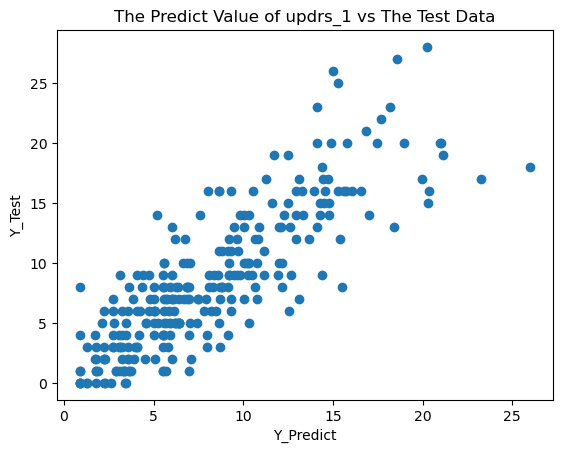

In [47]:
x = updrs_1_ar1[['updrs_1_lag6','updrs_1_lag12']]
# generate the predictor matrix
x = sm.add_constant(x)
# add constant items to predictor matrix
y = updrs_1_ar1.updrs_1
# generate the explained variable
x_train, x_test, y_train, y_test = train_test_split(
    x,y,test_size=0.2, random_state=0)
# split out dataset into train set and test set
lm = sm.OLS(y_train, x_train).fit()
# use sm.OLS model to do the multiple linear regression
print(lm.summary())
# print the results of our regression model
score = 1 - sum((lm.predict(x_test) - y_test)**2) / sum((
    y_test-np.mean(y_test))**2)
# calculate the accuracy score of our model, defined as the R-squared of test set
# we apply the model obtained from train set to the test set, get the prediction given predictors' values
# then R-squared of test set could be calculated
print('The accuracy of updrs_1 model is {}'.format(
    score))
y_pre = lm.predict(x_test)
plt.scatter(y_pre,y_test)
# draw the scatter plot describe the relationship between predicted value and true value
# if the points are located around the y=x line, the prediction of our model is good
plt.xlabel('Y_Predict')
plt.ylabel('Y_Test')
plt.title('The Predict Value of updrs_1 vs The Test Data')
plt.show()



# Updrs_2

In [48]:
clinical['updrs_2_lag3'] = np.nan
clinical['updrs_2_lag6'] = np.nan
clinical['updrs_2_lag9'] = np.nan
clinical['updrs_2_lag12'] = np.nan

for id in clinical.patient_id.unique():
    dt_id = clinical[clinical.patient_id == id]
    if dt_id.shape[0] == 1:
        continue
    for i in range(1,len(dt_id.index)):
        index = dt_id.index[i]
        if not dt_id[dt_id.visit_month == 
                     dt_id.visit_month[dt_id.index[i]] - 3 ].empty:
            lag3_index = dt_id[dt_id.visit_month == 
                               dt_id.visit_month[dt_id.index[i]] 
                               - 3 ].index[0]
            clinical['updrs_2_lag3'][index] =  clinical['updrs_2'][
                lag3_index]
        if not dt_id[dt_id.visit_month == 
                     dt_id.visit_month[dt_id.index[i]] - 6 ].empty:
            lag6_index = dt_id[dt_id.visit_month == 
                               dt_id.visit_month[dt_id.index[i]] 
                               - 6 ].index[0]
            clinical['updrs_2_lag6'][index] =  clinical['updrs_2'][
                lag6_index]
        if not dt_id[dt_id.visit_month == 
                     dt_id.visit_month[dt_id.index[i]] - 9 ].empty:
            lag9_index = dt_id[dt_id.visit_month == 
                               dt_id.visit_month[dt_id.index[i]] 
                               - 9 ].index[0]
            clinical['updrs_2_lag9'][index] =  clinical['updrs_2'][
                lag9_index]
        if not dt_id[dt_id.visit_month == 
                     dt_id.visit_month[dt_id.index[i]] - 12 ].empty:
            lag12_index = dt_id[dt_id.visit_month == 
                                dt_id.visit_month[dt_id.index[i]] 
                                - 12 ].index[0]
            clinical['updrs_2_lag12'][index] =  clinical['updrs_2'][
                lag12_index]

In [49]:
updrs_2_ar = clinical[['updrs_2','updrs_2_lag3',
                       'updrs_2_lag6','updrs_2_lag9','updrs_2_lag12']]
updrs_2_ar.corr()

,updrs_2,updrs_2_lag3,updrs_2_lag6,updrs_2_lag9,updrs_2_lag12
updrs_2,1.000000,0.847585,0.867223,0.772667,0.876249
updrs_2_lag3,0.847585,1.000000,0.850574,0.790805,0.820382
updrs_2_lag6,0.867223,0.850574,1.000000,0.861614,0.868269
updrs_2_lag9,0.772667,0.790805,0.861614,1.000000,0.834839
updrs_2_lag12,0.876249,0.820382,0.868269,0.834839,1.000000


In [50]:
updrs_2_ar1 = clinical[['updrs_2','updrs_2_lag6','updrs_2_lag12']]
print(updrs_2_ar1.shape)
updrs_2_ar1.dropna(axis = 0,inplace = True)
print(updrs_2_ar1.shape)

(2615, 3)
(1371, 3)


                            OLS Regression Results                            
Dep. Variable:                updrs_2   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     2106.
Date:                Wed, 03 May 2023   Prob (F-statistic):               0.00
Time:                        17:59:24   Log-Likelihood:                -2702.0
No. Observations:                1096   AIC:                             5410.
Df Residuals:                    1093   BIC:                             5425.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.6245      0.141      4.420

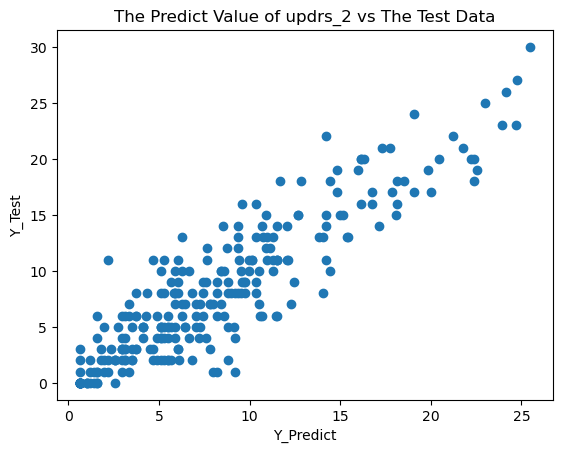

In [51]:
x = updrs_2_ar1[['updrs_2_lag6','updrs_2_lag12']]
x = sm.add_constant(x)
y = updrs_2_ar1.updrs_2
x_train, x_test, y_train, y_test = train_test_split(
    x,y,test_size=0.2, random_state=0)
lm = sm.OLS(y_train, x_train).fit()
print(lm.summary())
score = 1 - sum((lm.predict(x_test) - y_test)**2) / sum(
    (y_test-np.mean(y_test))**2)
print('The accuracy of updrs_2 model is {}'.format(
    score))
y_pre = lm.predict(x_test)
plt.scatter(y_pre,y_test)
plt.xlabel('Y_Predict')
plt.ylabel('Y_Test')
plt.title('The Predict Value of updrs_2 vs The Test Data')
plt.show()

# Updrs_3

In [52]:
clinical['updrs_3_lag3'] = np.nan
clinical['updrs_3_lag6'] = np.nan
clinical['updrs_3_lag9'] = np.nan
clinical['updrs_3_lag12'] = np.nan

for id in clinical.patient_id.unique():
    dt_id = clinical[clinical.patient_id == id]
    if dt_id.shape[0] == 1:
        continue
    for i in range(1,len(dt_id.index)):
        index = dt_id.index[i]
        if not dt_id[dt_id.visit_month == 
                     dt_id.visit_month[dt_id.index[i]] - 3 ].empty:
            lag3_index = dt_id[dt_id.visit_month == 
                               dt_id.visit_month[dt_id.index[i]] 
                               - 3 ].index[0]
            clinical['updrs_3_lag3'][index] =  clinical['updrs_3'][
                lag3_index]
        if not dt_id[dt_id.visit_month == 
                     dt_id.visit_month[dt_id.index[i]] - 6 ].empty:
            lag6_index = dt_id[dt_id.visit_month == 
                               dt_id.visit_month[dt_id.index[i]] 
                               - 6 ].index[0]
            clinical['updrs_3_lag6'][index] =  clinical['updrs_3'][
                lag6_index]
        if not dt_id[dt_id.visit_month == 
                     dt_id.visit_month[dt_id.index[i]] - 9 ].empty:
            lag9_index = dt_id[dt_id.visit_month == 
                               dt_id.visit_month[dt_id.index[i]] 
                               - 9 ].index[0]
            clinical['updrs_3_lag9'][index] =  clinical['updrs_3'][
                lag9_index]
        if not dt_id[dt_id.visit_month == 
                     dt_id.visit_month[dt_id.index[i]] - 12 ].empty:
            lag12_index = dt_id[dt_id.visit_month == 
                                dt_id.visit_month[dt_id.index[i]] 
                                - 12 ].index[0]
            clinical['updrs_3_lag12'][index] =  clinical['updrs_3'][
                lag12_index]

In [53]:
updrs_3_ar = clinical[['updrs_3','updrs_3_lag3',
                       'updrs_3_lag6','updrs_3_lag9','updrs_3_lag12']]
updrs_3_ar.corr()

,updrs_3,updrs_3_lag3,updrs_3_lag6,updrs_3_lag9,updrs_3_lag12
updrs_3,1.000000,0.793910,0.833490,0.696648,0.868997
updrs_3_lag3,0.793910,1.000000,0.798540,0.770478,0.730926
updrs_3_lag6,0.833490,0.798540,1.000000,0.821903,0.833980
updrs_3_lag9,0.696648,0.770478,0.821903,1.000000,0.773500
updrs_3_lag12,0.868997,0.730926,0.833980,0.773500,1.000000


In [54]:
updrs_3_ar1 = clinical[['updrs_3','updrs_3_lag6','updrs_3_lag12']]
updrs_3_ar1.dropna(axis = 0,inplace = True)

                            OLS Regression Results                            
Dep. Variable:                updrs_3   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     1600.
Date:                Wed, 03 May 2023   Prob (F-statistic):          1.53e-321
Time:                        17:59:27   Log-Likelihood:                -3631.3
No. Observations:                1068   AIC:                             7269.
Df Residuals:                    1065   BIC:                             7284.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.8823      0.428      4.394

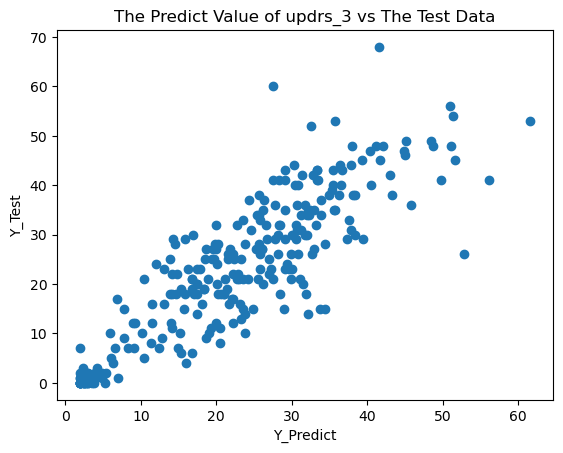

In [55]:
x = updrs_3_ar1[['updrs_3_lag6','updrs_3_lag12']]
x = sm.add_constant(x)
y = updrs_3_ar1.updrs_3
x_train, x_test, y_train, y_test = train_test_split(
    x,y,test_size=0.2, random_state=0)
lm = sm.OLS(y_train, x_train).fit()
print(lm.summary())
score = 1 - sum((lm.predict(x_test) - y_test)**2) / sum(
    (y_test-np.mean(y_test))**2)
print('The accuracy of updrs_3 is {}'.format(
    score))
y_pre = lm.predict(x_test)
plt.scatter(y_pre,y_test)
plt.xlabel('Y_Predict')
plt.ylabel('Y_Test')
plt.title('The Predict Value of updrs_3 vs The Test Data')
plt.show()

# Updrs_4

In [56]:
clinical['updrs_4_lag3'] = np.nan
clinical['updrs_4_lag6'] = np.nan
clinical['updrs_4_lag9'] = np.nan
clinical['updrs_4_lag12'] = np.nan

for id in clinical.patient_id.unique():
    dt_id = clinical[clinical.patient_id == id]
    if dt_id.shape[0] == 1:
        continue
    for i in range(1,len(dt_id.index)):
        index = dt_id.index[i]
        if not dt_id[dt_id.visit_month == 
                     dt_id.visit_month[dt_id.index[i]] - 3 ].empty:
            lag3_index = dt_id[dt_id.visit_month == 
                               dt_id.visit_month[dt_id.index[i]] 
                               - 3 ].index[0]
            clinical['updrs_4_lag3'][index] =  clinical['updrs_4'][
                lag3_index]
        if not dt_id[dt_id.visit_month == 
                     dt_id.visit_month[dt_id.index[i]] - 6 ].empty:
            lag6_index = dt_id[dt_id.visit_month == 
                               dt_id.visit_month[dt_id.index[i]] 
                               - 6 ].index[0]
            clinical['updrs_4_lag6'][index] =  clinical['updrs_4'][
                lag6_index]
        if not dt_id[dt_id.visit_month == 
                     dt_id.visit_month[dt_id.index[i]] - 9 ].empty:
            lag9_index = dt_id[dt_id.visit_month == 
                               dt_id.visit_month[dt_id.index[i]] 
                               - 9 ].index[0]
            clinical['updrs_4_lag9'][index] =  clinical['updrs_4'][
                lag9_index]
        if not dt_id[dt_id.visit_month == 
                     dt_id.visit_month[dt_id.index[i]] - 12 ].empty:
            lag12_index = dt_id[dt_id.visit_month == 
                                dt_id.visit_month[dt_id.index[i]] 
                                - 12 ].index[0]
            clinical['updrs_4_lag12'][index] =  clinical['updrs_4'][
                lag12_index]

In [57]:
updrs_4_ar = clinical[['updrs_4','updrs_4_lag3',
                       'updrs_4_lag6','updrs_4_lag9','updrs_4_lag12']]
updrs_4_ar.corr()

,updrs_4,updrs_4_lag3,updrs_4_lag6,updrs_4_lag9,updrs_4_lag12
updrs_4,1.000000,0.441731,0.698337,0.434402,0.684303
updrs_4_lag3,0.441731,1.000000,NaN,1.000000,NaN
updrs_4_lag6,0.698337,NaN,1.000000,0.536499,0.718773
updrs_4_lag9,0.434402,1.000000,0.536499,1.000000,NaN
updrs_4_lag12,0.684303,NaN,0.718773,NaN,1.000000


In [58]:
updrs_4_ar1 = clinical[['updrs_4','updrs_4_lag6','updrs_4_lag12']]
print(updrs_4_ar1.shape)
updrs_4_ar1.dropna(axis = 0,inplace = True)
print(updrs_4_ar1.shape)

(2615, 3)
(901, 3)


                            OLS Regression Results                            
Dep. Variable:                updrs_4   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     467.7
Date:                Wed, 03 May 2023   Prob (F-statistic):          1.02e-130
Time:                        17:59:29   Log-Likelihood:                -1532.6
No. Observations:                 720   AIC:                             3071.
Df Residuals:                     717   BIC:                             3085.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5301      0.089      5.940

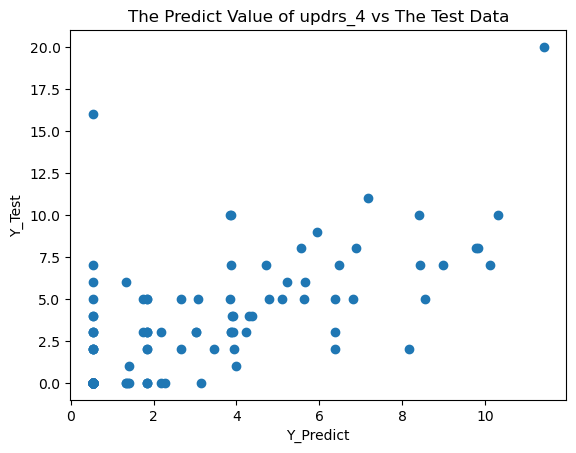

In [59]:
x = updrs_4_ar1[['updrs_4_lag6','updrs_4_lag12']]
x = sm.add_constant(x)
y = updrs_4_ar1.updrs_4
x_train, x_test, y_train, y_test = train_test_split(
    x,y,test_size=0.2, random_state=0)
lm = sm.OLS(y_train, x_train).fit()
print(lm.summary())
score = 1 - sum((lm.predict(x_test) - y_test)**2) / sum(
    (y_test-np.mean(y_test))**2)
print('The accuracy of updrs_4 model is {}'.format(
    score))
y_pre = lm.predict(x_test)
plt.scatter(y_pre,y_test)
plt.xlabel('Y_Predict')
plt.ylabel('Y_Test')
plt.title('The Predict Value of updrs_4 vs The Test Data')
plt.show()